In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

In [2]:
import numpy as np

In [3]:
import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow

import brasa

<Axes: >

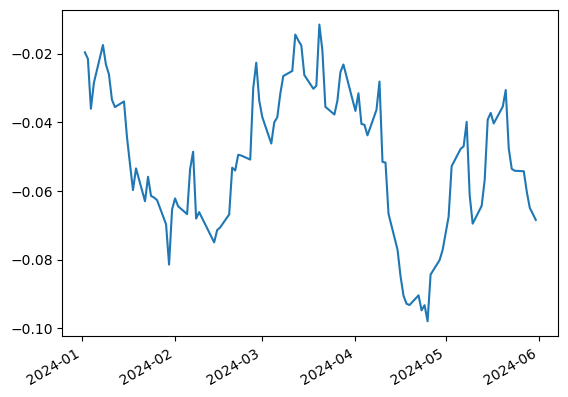

In [4]:
symbols = [
    "ABEV3",
    "ARZZ3",
    "B3SA3",
    "BBAS3",
    "EGIE3",
    "EZTC3",
    "INTB3",
    "ITSA4",
    "PSSA3",
    "WEGE3",
    "QBTC11",
    "ACWI11",
    "XFIX11",
]

positions = pd.Series([
    1300.0,
    300.0,
    1000.0,
    400.0,
    800.0,
    800.0,
    500.0,
    1732.5,
    1000.0,
    100.0,
    161.0,
    545.0,
    141.0,
], index=symbols)

df = brasa.get_dataset("b3-cotahist")\
    .filter(pc.field("symbol").isin(symbols))\
    .filter(pc.field("refdate") == datetime(2024, 1, 5))\
    .scanner(columns=["refdate", "symbol", "close"])\
    .to_table()\
    .to_pandas()

# df["close"] = df["close"]*positions
# df.style.format({"close": "{:,.2f}", "volume": "{:,.2f}"})

portfolio = df.pivot(index="refdate", columns="symbol", values="close") * positions

weights = portfolio / portfolio.sum(axis=1).iloc[0]
weights = weights.iloc[0]
weights.name = None

rets = brasa.get_returns(symbols, start=datetime(2024, 1, 1))

portfolio_returns = (rets * weights).sum(axis=1)

portfolio_returns.cumsum().plot()

In [11]:
display(rets.sum().sort_values())
(rets.sum() * weights).sum()

EZTC3    -0.358483
B3SA3    -0.291044
ARZZ3    -0.266971
ABEV3    -0.172395
ITSA4    -0.026800
EGIE3    -0.015798
BBAS3    -0.002292
XFIX11    0.018198
WEGE3     0.027501
PSSA3     0.065765
INTB3     0.072370
ACWI11    0.160884
QBTC11    0.503792
dtype: float64

-0.0684426836765636

In [12]:
rets.std() * np.sqrt(252)

ABEV3     0.183905
ACWI11    0.103448
ARZZ3     0.388194
B3SA3     0.259570
BBAS3     0.172823
EGIE3     0.203770
EZTC3     0.400891
INTB3     0.398545
ITSA4     0.176805
PSSA3     0.260416
QBTC11    0.515099
WEGE3     0.199655
XFIX11    0.054169
dtype: float64

<Axes: >

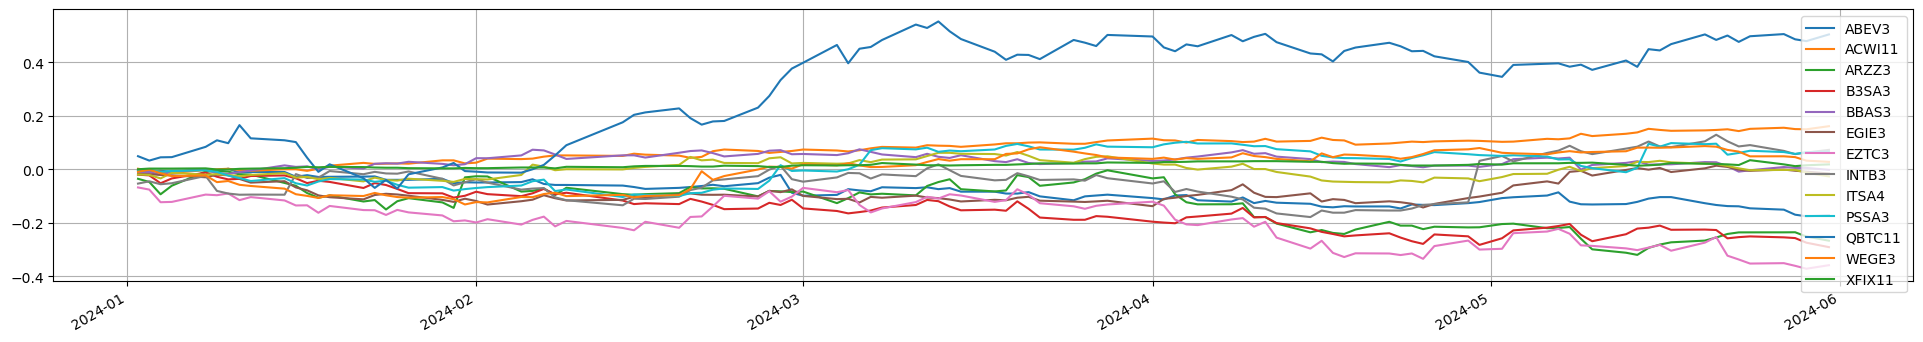

In [13]:
rets.cumsum().plot(grid=True, figsize=(24, 4))

In [14]:
portfolio_returns.std() * np.sqrt(252)

0.13832839008609799

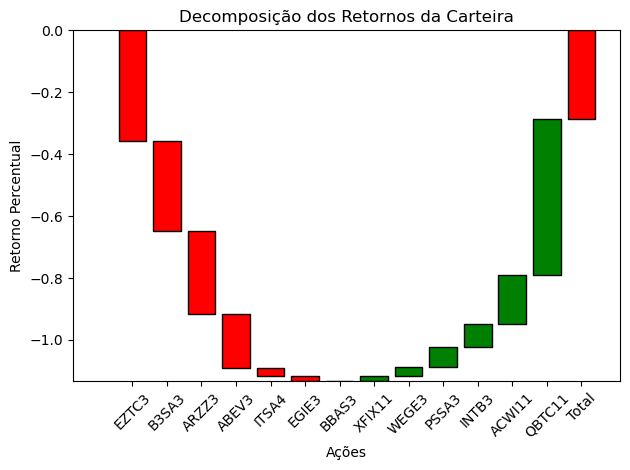

In [15]:
import matplotlib.pyplot as plt

# Exemplo de dados
retornos = rets.sum().sort_values()
acoes = retornos.index
retorno_carteira = rets.sum().sum()

# Cálculo do início de cada barra
start = 0
starts = [start]
for retorno in retornos[:-1]:
    start += retorno
    starts.append(start)

cores = ['green' if retorno >= 0 else 'red' for retorno in retornos]

# Criação do gráfico waterfall
fig, ax = plt.subplots()
for i, (acao, retorno, cor) in enumerate(zip(acoes, retornos, cores)):
    ax.bar(acao, retorno, bottom=starts[i], color=cor, edgecolor='black')

# Adicionar o retorno total com uma cor específica se for positivo ou negativo
cor_total = 'green' if retorno_carteira >= 0 else 'red'
ax.bar('Total', retorno_carteira, bottom=0, edgecolor='black', color=cor_total)

# Adiciona linhas para melhor visualização
ax.plot([-1, len(acoes)], [0, 0], color='black', linewidth=0.5)

# Configurações adicionais
ax.set_title('Decomposição dos Retornos da Carteira')
ax.set_ylabel('Retorno Percentual')
ax.set_xlabel('Ações')
plt.xticks(rotation=45)  # Rotação dos labels no eixo x para melhor visualização
plt.tight_layout()
plt.show()
